**Gas Data**

Imports

In [2]:
import numpy as np 
import matplotlib.pyplot as plt #for plotting graphs 
import pandas as pd
import statistics as stats #for calculating variance - Stack Overflow

Organize Know Data

In [3]:
gas_data = pd.read_csv("gas_price_data.txt", delimiter='\t', header= 2) #read file
#seperate values by commas (read as csv), seperate lines by tab (delimiter = '\t') and ignore the first 2 lines (header = 2)

gas_data = gas_data.rename(columns={'Unnamed: 0':'Date'}) #give date a header 
gas_data["Date"] = pd.to_datetime(gas_data["Date"], format = "%b %d, '%y") #convert dates to YYYY-MM-DD format 

first_date = gas_data["Date"].min() #earliest given date
last_date = gas_data["Date"].max() #latest given date 
future_dates = pd.Timedelta(days= 7) #will increase the number of days by 7 - adding 7 creates Type Error 
gas_dates = pd.date_range(first_date, last_date + future_dates, freq= 'D') #create a list of dates by day from the earliest given date to seven days in the future

gas_data = gas_data.set_index("Date") #sets the date column as the index 
gas_data = gas_data.reindex(gas_dates) #add all the missing dates to the index 
gas_data = gas_data.reset_index() #give each row an index - now the missing dates have an index and the date is not the index
gas_data = gas_data.rename(columns= {'index': "Date"}) #fix header name 


gas_data['x-value'] = gas_data.index.astype(int) / 7 # create a new column 
#divide the index of the number by 7 for a week scale


**Approximation**

In [4]:
#turn data series into an numpy arrays to make them easier to work with 
known_diesel_price = np.array(gas_data["Diesel"])  
known_regular_price = np.array(gas_data["Regular"])
x_vals = np.array(gas_data["x-value"]) #index divided by 7 

noise = np.random.normal(0, 1.5, size= gas_data["Regular"].shape) #create noise  - a smaller standard deviation would yield better results 
for i in range(len(gas_data["Regular"])): #remove noise for known values 
    if not pd.isna(known_regular_price[i]): 
         noise[i] = 0 #set noise at known values to 0 

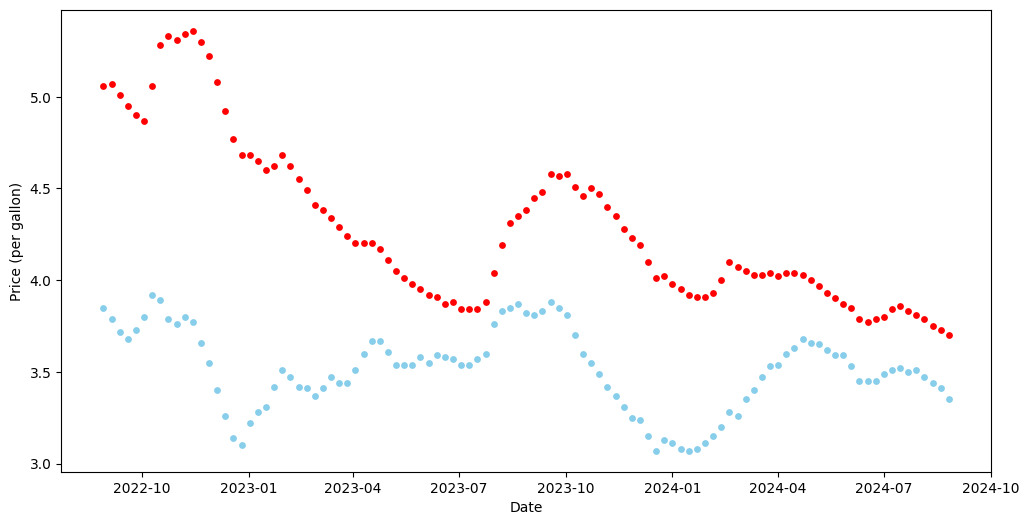

In [5]:
#plot known points 
plt.figure(figsize=(12,6))
plt.scatter(gas_data["Date"], known_regular_price, color = "skyblue", s=15) #plot known points 
plt.scatter(gas_data["Date"], known_diesel_price, color = "red", s= 15) # s changes size of point 
plt.xlabel("Date")
plt.ylabel("Price (per gallon)")
plt.show()

Find nearest point functions

In [6]:
def point_under(x: np.array, y:np.array, point_to_est: float) -> np.array: 
    """Find the closest point under a point we want to estimate"""
    index_num = 0
    x_close =  x[np.argsort(np.abs(x-point_to_est))]#use code from linear approximations in class to find point over and point under
    point_under = x_close[index_num] #initialize value as closest point 
    while (point_under > point_to_est) or (pd.isna(y[np.where(x == point_under)])): #make sure the point is below and has a known price 
            index_num += 1
            point_under = x_close[index_num] # go to next number
                  
    return point_under

def next_point_under(x: np.array, y: np.array, point_to_est: float, closest_point_under: float, second_point_under: float = -1.0) -> np.array: 
    """Find the next closest point under a point we want to estimate"""
    index_num = 0
    x_close =  x[np.argsort(np.abs(x-point_to_est))]#use code from linear approximations in class to find point over and point under
    next_point_under = x_close[index_num] #initialize value as closest point 
    while (next_point_under > point_to_est) or (pd.isna(y[np.where(x == next_point_under)])) or (next_point_under == closest_point_under) or (next_point_under == second_point_under): #make sure the point is below, has a known price, and is not the same as the other points under
            index_num += 1
            if index_num >= len(x): #if the number would be out of range of the index then no point that fills conditions exists 
                next_point_under = None 
                break #stop loop 
            else: 
                next_point_under = x_close[index_num] #move to the next possible point
    
                  
    return next_point_under

def point_over(x: np.array, y:np.array, point_to_est: float) -> np.array: 
    """Find the closest point above a point we want to estimate"""
    index_num = 0
    x_close =  x[np.argsort(np.abs(x-point_to_est))]#use code from linear approximations in class to find point over and point under
    point_over = x_close[index_num] #initialize value as closest point
    while (point_over < point_to_est) or (pd.isna(y[np.where(x == point_over)])): #make sure the point is above and has a known price 
        index_num += 1
        if index_num >= len(x): 
            point_over = None #if such a point does not exist return none
            break 
        else: 
            point_over = x_close[index_num] #move to the next possible point
        
    return point_over

def next_point_over(x: np.array, y:np.array, point_to_est: float, closest_point_over: float) -> np.array: 
    """find the next closest point above a point we are trying to estimate"""
    index_num = 0
    x_close =  x[np.argsort(np.abs(x-point_to_est))]#use code from linear approximations in class to find point over and point under
    next_point_over = x_close[index_num] #initialize value as closest point
    while (next_point_over< point_to_est) or (pd.isna(y[np.where(x == next_point_over)])) or (next_point_over == closest_point_over): #make sure the point is above, has a known price and is not the same as the point over
        index_num += 1
        if index_num >= len(x): 
            next_point_over = None #if a point does not exist return none
            break 
        else: 
            next_point_over = x_close[index_num] #move to the next possible point 

    return next_point_over



**Linear Approximation**

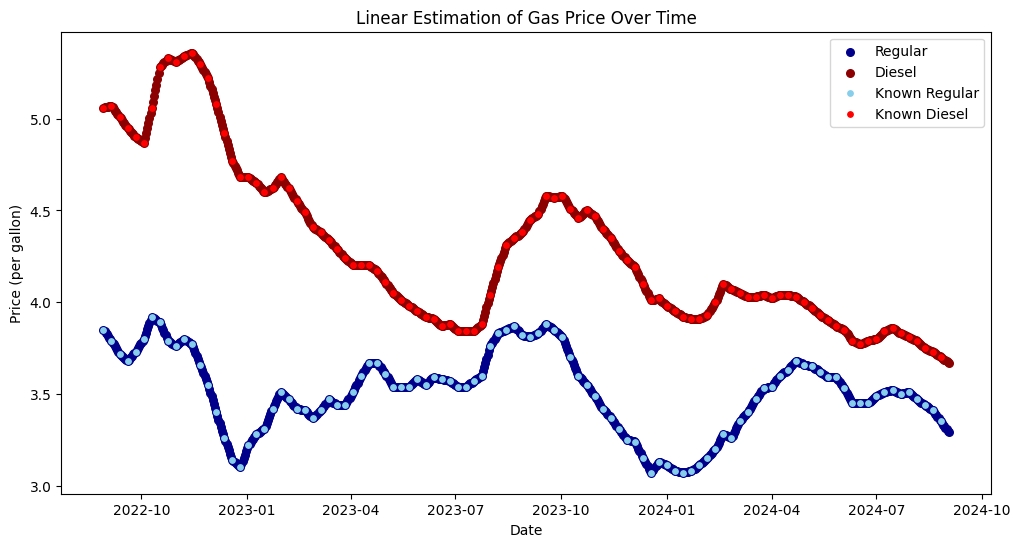

Varience of Regular:  0.046455320303587275
Varience of Diesel:  0.1980374608368192


In [7]:

def linear_approximation(x: np.array, y: np.array) -> np.array:
    """Make a linear approximation for missing values in an array""" 
    complete_y = y.copy() #copy known values so I don't use estimated values in future estimations 
    for i in range(len(y)):
        if pd.isna(y[i]): #if there is no set y value make an estimation 
            point_to_est = x[i]
         
            #find closest point under - there will always be a point under that has a value because x[0] has a value
            point_under_x = point_under(x, y, point_to_est)
            point_under_y = y[np.where(x == point_under_x)] #find the price at that point 
              
            #find closest point above - if there is not a point above use the next point below
            point_over_x = point_over(x, y, point_to_est)
            if point_over_x == None: #if a point over does not exist, use the another point under 
                point_over_x = next_point_under(x, y, point_to_est, point_under_x)
            point_over_y = y[np.where(x == point_over_x)] 
            
            slope = (point_over_y - point_under_y)/(point_over_x - point_under_x) #estimate slope
            y_est = slope * (point_to_est - point_under_x) + point_under_y  # estimate point 
            complete_y[i] = y_est[0] #replace missing value with estimation 
            
    return complete_y
    
gas_data_lin = gas_data.copy() #create a copy of the data so empty spaces stay empty 
gas_data_lin["Regular"] = linear_approximation(x_vals, known_regular_price) #estimate regular prices 
gas_data_lin["Diesel"] = linear_approximation(x_vals, known_diesel_price) #estimate diesel prices 
gas_data_lin.to_csv("Linear Gas Data.csv")#save to csv 


#graph 
plt.figure(figsize=(12,6)) #increase figure size for readability
plt.scatter(gas_data_lin["Date"], gas_data_lin["Regular"], color="darkblue", s= 30) #plot estimation
plt.scatter(gas_data_lin["Date"], gas_data_lin["Diesel"], color="darkred", s=30) #change color - color list from matplotlib.org
plt.scatter(gas_data_lin["Date"], known_regular_price, color = "skyblue", s=15) #plot known points 
plt.scatter(gas_data_lin["Date"], known_diesel_price, color = "red", s= 15) # s changes size of point 
plt.legend(["Regular", "Diesel", "Known Regular", "Known Diesel"]) #add legend
plt.title("Linear Estimation of Gas Price Over Time") 
plt.xlabel("Date")
plt.ylabel("Price (per gallon)")
plt.show()

#variance 
print("Varience of Regular: ", stats.variance(gas_data_lin["Regular"]))
print("Varience of Diesel: ", stats.variance(gas_data_lin["Diesel"]))

**Linear Approximation with Noise**

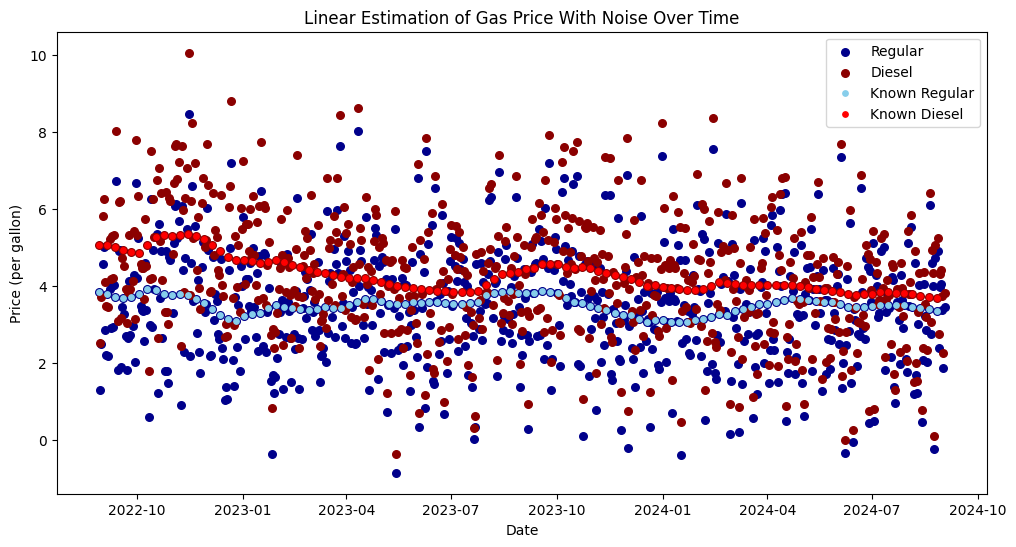

Varience of Regular:  2.0636494425096004
Varience of Diesel:  2.291499767117503


In [8]:


#add noise to linear approximation
gas_data_lin["Regular"] += noise #add noise to linear approximated regular price 
gas_data_lin["Diesel"] += noise #add noise to linear approximated diesel price
gas_data_lin.to_csv("Noisy Linear Gas Data.csv") #save to csv

#graph 
plt.figure(figsize=(12,6)) #increase figure size for readability
plt.scatter(gas_data_lin["Date"], gas_data_lin["Regular"], color="darkblue", s= 30) #plot estimation
plt.scatter(gas_data_lin["Date"], gas_data_lin["Diesel"], color="darkred", s=30) 
plt.scatter(gas_data_lin["Date"], known_regular_price, color = "skyblue", s=15) #plot known points 
plt.scatter(gas_data_lin["Date"], known_diesel_price, color = "red", s= 15) 
plt.legend(["Regular","Diesel", "Known Regular", "Known Diesel"]) #add legend
plt.title("Linear Estimation of Gas Price With Noise Over Time") 
plt.xlabel("Date")
plt.ylabel("Price (per gallon)")
plt.show() 

#variance - varience is really high
print("Varience of Regular: ", stats.variance(gas_data_lin["Regular"]))
print("Varience of Diesel: ", stats.variance(gas_data_lin["Diesel"]))

**Quadratic Approximation**

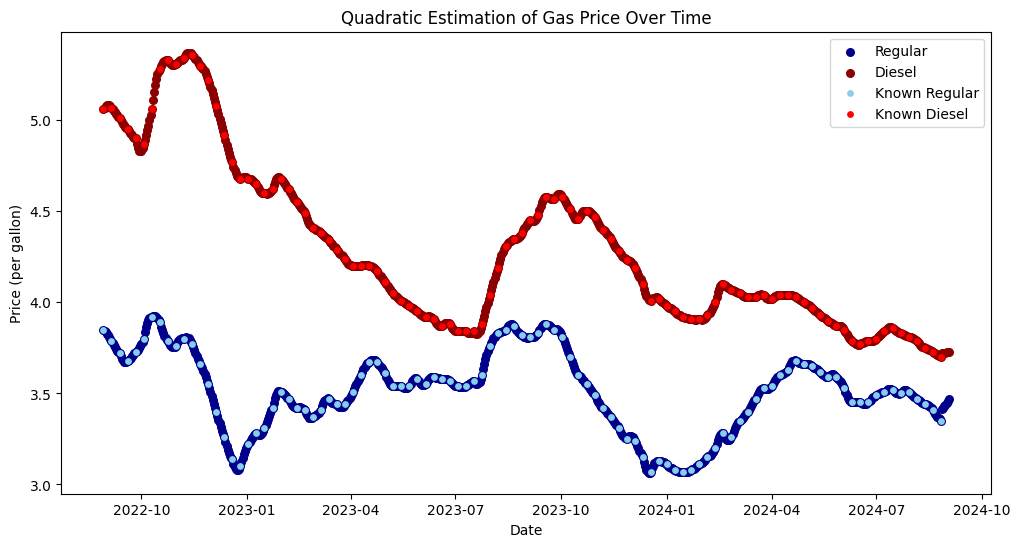

Varience of Regular:  0.047074852654911944
Varience of Diesel:  0.19868431300384637


In [9]:
def quadratic_approximation(x: np.array, y:np.array) -> np.array: 
    """Use a quadratic approximation to fill in missing data points"""
    complete_y = y.copy() #copy prices so estimations are not made with previously estimated points 
    for i in range(len(y)): 
        if pd.isna(y[i]): #if there is not a known price make an approximation
            point_to_est = x[i]
            
            #find the 3 closest points 
            point_one_x = point_under(x, y, point_to_est) #there will always be a point under
            point_one_y = y[np.where(x == point_one_x)] #find the price for that value 
            
            point_two_x = point_over(x, y, point_to_est)
            if point_two_x == None: #if there is not a point over use the next point under 
                point_two_x = next_point_under(x, y, point_to_est, point_one_x)
            point_two_y = y[np.where(x == point_two_x)] 
            
            point_three_x = next_point_over(x, y, point_to_est, point_two_x)
            if point_three_x == None: #if there is not another point over use point under instead
                point_three_x = next_point_under(x, y, point_to_est, point_one_x, point_two_x) #make sure point under isn't equal to point two
            point_three_y = y[np.where(x == point_three_x)]
            
            #First derivative -change in price divided by change in time
            distance_one = point_two_x -point_one_x
            slope_one = (point_two_y - point_one_y)/distance_one 
            
            distance_two = point_three_x - point_two_x
            slope_two = (point_three_y - point_two_y)/distance_two
            
            #second derivative - change in slope divided by average change in time 
            second_derivative = (slope_two - slope_one)/((abs(distance_one) + abs(distance_two))/ 2) 
            
            #f(a) + f'(a)(x-a) + f''(a)(x-a)^2
            if distance_one < distance_two: #use the slope between the closer points 
                y_est = point_two_y + (slope_one * (point_to_est - point_two_x)) + (second_derivative * (point_to_est - point_two_x)**2)
            else: 
                y_est = point_two_y + (slope_two * (point_to_est - point_two_x)) + (second_derivative * (point_to_est - point_two_x)**2)
            
            complete_y[i] = y_est[0] #replace missing value with estimate

    return complete_y

gas_data_quad = gas_data.copy() #copy data so empty cells stay empty
gas_data_quad["Regular"] = quadratic_approximation(x_vals, known_regular_price) #quadratic appriximation of regular price 
gas_data_quad["Diesel"] = quadratic_approximation(x_vals, known_diesel_price) #quadratic approximation of diesel price 
gas_data_quad.to_csv("Quadratic Gas Data.csv") # save to csv 

#graph 
plt.figure(figsize=(12,6)) #increase figure size for readability
plt.scatter(gas_data_quad["Date"], gas_data_quad["Regular"], color="darkblue", s= 30) #plot estimation
plt.scatter(gas_data_quad["Date"], gas_data_quad["Diesel"], color="darkred", s=30)
plt.scatter(gas_data_quad["Date"], known_regular_price, color = "skyblue", s=15) #plot known points 
plt.scatter(gas_data_quad["Date"], known_diesel_price, color = "red", s= 15) 
plt.legend(["Regular","Diesel", "Known Regular", "Known Diesel"]) #add legend
plt.title("Quadratic Estimation of Gas Price Over Time") 
plt.xlabel("Date")
plt.ylabel("Price (per gallon)")
plt.show() 

print("Varience of Regular: ", stats.variance(gas_data_quad["Regular"]))
print("Varience of Diesel: ", stats.variance(gas_data_quad["Diesel"]))   
    

**Noisy Quadratic**

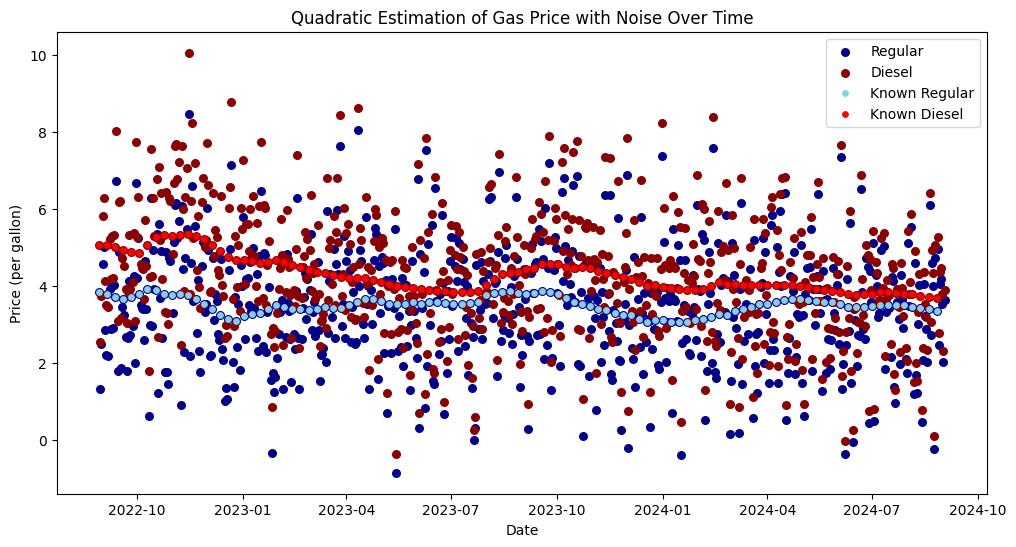

Varience of Regular:  2.0631374824661637
Varience of Diesel:  2.291879524707607


In [10]:
#add noise to quadratic approximation
gas_data_quad["Regular"] += noise
gas_data_quad["Diesel"] += noise 
gas_data_quad.to_csv("Noisy Quadratic Gas Data.csv")


#graph 
plt.figure(figsize=(12,6)) #increase figure size for readability
plt.scatter(gas_data_quad["Date"], gas_data_quad["Regular"], color="darkblue", s= 30) #plot estimation
plt.scatter(gas_data_quad["Date"], gas_data_quad["Diesel"], color="darkred", s=30) 
plt.scatter(gas_data_quad["Date"], known_regular_price, color = "skyblue", s=15) #plot known points 
plt.scatter(gas_data_quad["Date"], known_diesel_price, color = "red", s= 15) 
plt.legend(["Regular","Diesel", "Known Regular", "Known Diesel"]) #add legend
plt.title("Quadratic Estimation of Gas Price with Noise Over Time") 
plt.xlabel("Date")
plt.ylabel("Price (per gallon)")
plt.show() 

print("Varience of Regular: ", stats.variance(gas_data_quad["Regular"]))
print("Varience of Diesel: ", stats.variance(gas_data_quad["Diesel"]))


**Hot Deck**

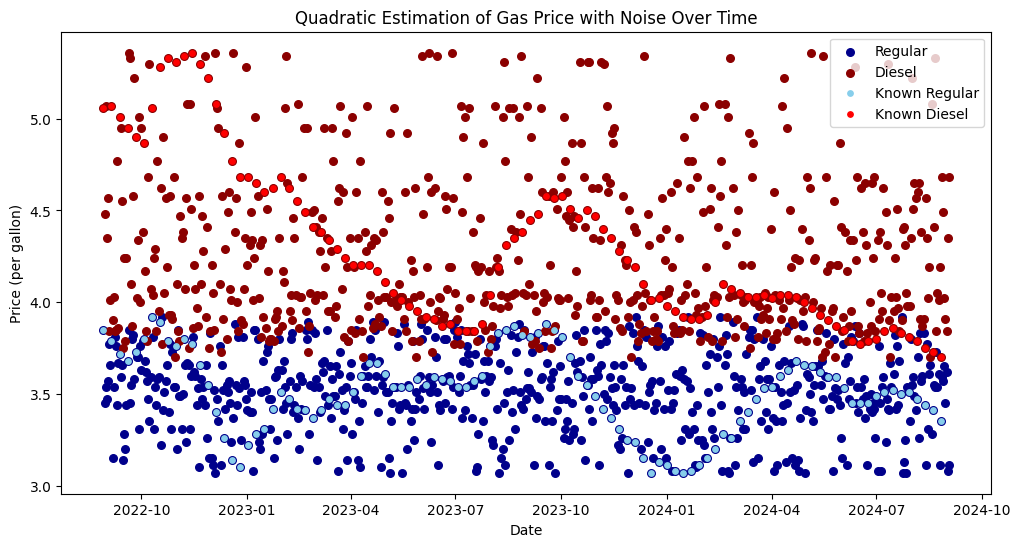

Varience of Regular:  0.047901159235433304
Varience of Diesel:  0.18747455486542441


In [11]:
def hot_deck_approximation(known_data: np.array) -> np.array: 
    hot_deck_est = known_data.copy()
    known_prices = [] #create an array of known prices for regular and diesel - no Nan
    for i in range(len(hot_deck_est)):
        if not pd.isna(hot_deck_est[i]):
            known_prices.append(hot_deck_est[i]) #if the index has a known value add it to the list of known prices 
    rand_int = np.random.randint(0, len(known_prices), size= hot_deck_est.shape) #create a list of random numbers the length of the data set using valuess from the list of known prices that does not have Nan values
    for i in range(len(hot_deck_est)):
        if pd.isna(hot_deck_est[i]): #if there is not a known value
            hot_deck_est[i] = known_prices[rand_int[i]] #replace any unknown value with a known value of random index   
    return hot_deck_est
    
hot_deck_data = gas_data.copy() 
hot_deck_data["Regular"] = hot_deck_approximation(known_regular_price) #hot deck estimate regular price
hot_deck_data["Diesel"] = hot_deck_approximation(known_diesel_price) #hot deck estimate diesel price
hot_deck_data.to_csv("Hot Deck Gas Data.csv") #save to csv 

#graph 
plt.figure(figsize=(12,6)) #increase figure size for readability
plt.scatter(hot_deck_data["Date"], hot_deck_data["Regular"], color="darkblue", s= 30) #plot estimation
plt.scatter(hot_deck_data["Date"], hot_deck_data["Diesel"], color="darkred", s=30) #color changes color - googled color options: matplotlib.org
plt.scatter(hot_deck_data["Date"], known_regular_price, color = "skyblue", s=15) #plot known points 
plt.scatter(hot_deck_data["Date"], known_diesel_price, color = "red", s= 15) # s= changes size of point 
plt.legend(["Regular","Diesel", "Known Regular", "Known Diesel"]) #add legend
plt.title("Quadratic Estimation of Gas Price with Noise Over Time") 
plt.xlabel("Date")
plt.ylabel("Price (per gallon)")
plt.show() 

print("Varience of Regular: ", stats.variance(hot_deck_data["Regular"]))
print("Varience of Diesel: ", stats.variance(hot_deck_data["Diesel"]))
        


**Write-Up**

Linear approximation takes the two closest points to the missing data point and uses them to estimate the missing value. Quadratic approximation takes the three closest points to the missing data and uses them to estimate the missing value. Quadratic approximation provided the best method for filling in the missing data because it uses more known data to make an estimation. However, linear approximation provided the best projection into the future. Since there are no points ahead of the future estimation, the points behind must be used. Using three points behind in the quadratic approximation skews the estimated points. This can clearly be seen in the quadratic approximation graph whereas the linear approximation continues smoothly using two points below. Gas price tends to have a somewhat linear trend but is not truly linear. Adding noise may have improved the estimations if the standard deviation for the noise generation was not so large. Due to the large noise both the noisy linear and noisy quadratic approximations have have a very high variance and are not good approximations of the missing or future data. The hot deck approximation pulls from known values however the price shifts according to past price so randomly selecting a price is not a great estimation method for this type of data. I have never used csv or pandas before so I got help from websites, such as Stack Overflow, W3 Schools, and ChatGPT, as well as other class memebers, mainly Sepehr Akbari, to complete this project. 
